In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import yaml
class undistrodMarkers:
    def __init__(self,config_file_name):
        with open(config_file_name, 'r') as f:
            calib = yaml.safe_load(f.read())
        self.K = np.array(calib['camera_matrix']['data']).reshape(calib['camera_matrix']['rows'],calib['camera_matrix']['cols'])
        self.D = np.array(calib['distortion_coefficients']['data']).reshape(-1, 5)
        self.P = np.array(calib['projection_matrix']['data']).reshape(3, 4)
        self.R = np.array(calib['rectification_matrix']['data']).reshape(3, 3)
        self.img_width = calib['image_width']
        self.img_height = calib['image_height']
    def process(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D,P=self.P,R=self.R)
        return lpts_ud#cv2.convertPointsToHomogeneous(np.float32(lpts_ud))

distorsionProcessor = undistrodMarkers('ost.yaml')


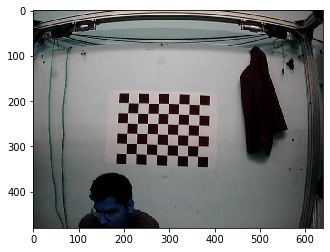

In [4]:
img=cv2.imread('calibration_image.jpg')
plt.imshow(img)

In [5]:
pattern_size = (6, 8)
img_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
found, corners = cv2.findChessboardCorners(img_gray, pattern_size)
stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
                 30, 0.001)
corners_subpixel=cv2.cornerSubPix(img_gray, corners, (11, 11), (-1, -1), stop_criteria)


In [6]:
corners_undistorded=distorsionProcessor.process(corners_subpixel)

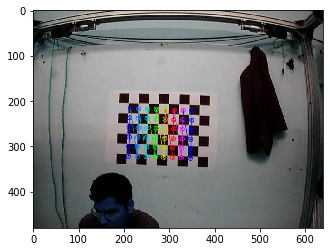

In [8]:
img=cv2.imread('calibration_image.jpg')
result_image=cv2.drawChessboardCorners(img, pattern_size,corners_undistorded,found)
plt.imshow(img)

In [9]:
square_size=79.4
ys=(np.array([i for i in range(0,6)]))*square_size
xs=np.array([i for i in range(0,8)])*square_size
f=np.array(np.meshgrid(xs,ys))


In [10]:
world = f.transpose(2, 1, 0).reshape(48, 2)

In [11]:
H, mask = cv2.findHomography(corners_undistorded.reshape(-1, 1, 2),world.reshape(-1, 1, 2))

In [12]:
(corners_undistorded.reshape(-1, 1, 2)[0,:,:],world.reshape(-1, 1, 2)[0,:,:])

(array([[210.24847, 320.6032 ]], dtype=float32), array([[0., 0.]]))

In [13]:
H

array([[ 4.16459358e+00,  1.42919722e-01, -9.21377151e+02],
       [ 1.52111134e-01, -3.86960746e+00,  1.20866977e+03],
       [ 4.74315495e-05,  3.27355954e-05,  1.00000000e+00]])

In [16]:
a=np.matmul(H, np.hstack((corners_undistorded[2][0], 1)))
a=a/a[2]
a

array([3.15211445e-02, 1.58791704e+02, 1.00000000e+00])

In [17]:
with open('extrinsic_params.yaml','w') as f:
    yaml.dump(H.tolist(),f)
    

In [19]:
corners_subpixel[0]

array([[206.06908, 316.38974]], dtype=float32)